In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy import stats
from pathlib import Path

In [55]:
aapl = yfinance_log_return('AAPL')

In [2]:
start_date = '1994-01-01'
end_date = '2014-06-01'

cols, parse_dates = ['permno', 'ret', 'date'], ['date']
dtypes = {
    'permno': np.uint32,
    'ret': np.float32
}

raw_data = pd.read_csv('data/characteristics_data_feb2017.csv', usecols=cols, dtype=dtypes, parse_dates=parse_dates)
raw_data = raw_data.pivot(index='date', columns='permno', values='ret')
raw_data = raw_data[start_date:end_date].dropna(axis='columns')
r = np.log(raw_data + 1)

In [41]:
spy_file = Path('data/spy.csv')

if spy_file.exists():
    spy_price = pd.read_csv('data/spy.csv', names=['Date', 'Close'], index_col='Date', parse_dates=True).squeeze()
else:
    spy_price = yf.download(['SPY'], start=start_date, end=end_date, interval='1d', back_adjust=True, progress=False)['Close', 'SPY']
    
spy = np.log(spy_price.resample('ME').last()) - np.log(spy_price.resample('ME').first())

In [107]:
res = [stats.linregress(spy, r[i]) for i in r]
alpha = np.array([res_i.intercept for res_i in res])
beta = np.array([res_i.slope for res_i in res])

In [128]:
residuals = r - (np.reshape(spy, (len(spy), 1)) @ beta.reshape(1, len(beta)) + alpha)

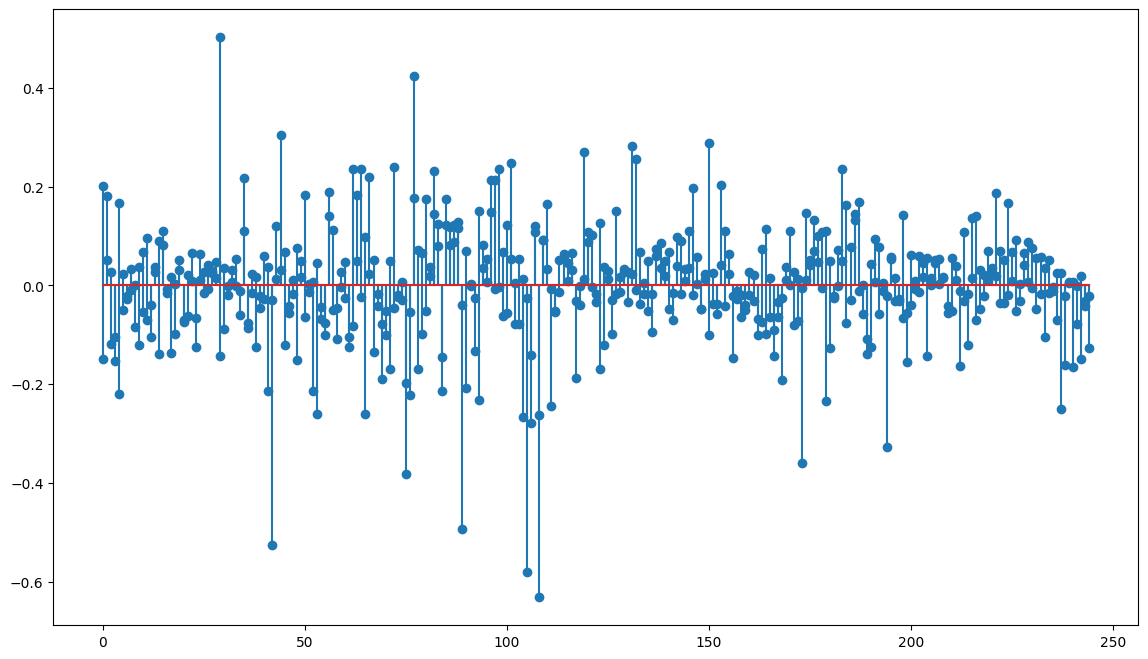

In [153]:
plt.figure(figsize=(14, 8))
plt.stem(residuals[10026])
plt.stem(residuals[10025])
plt.show()

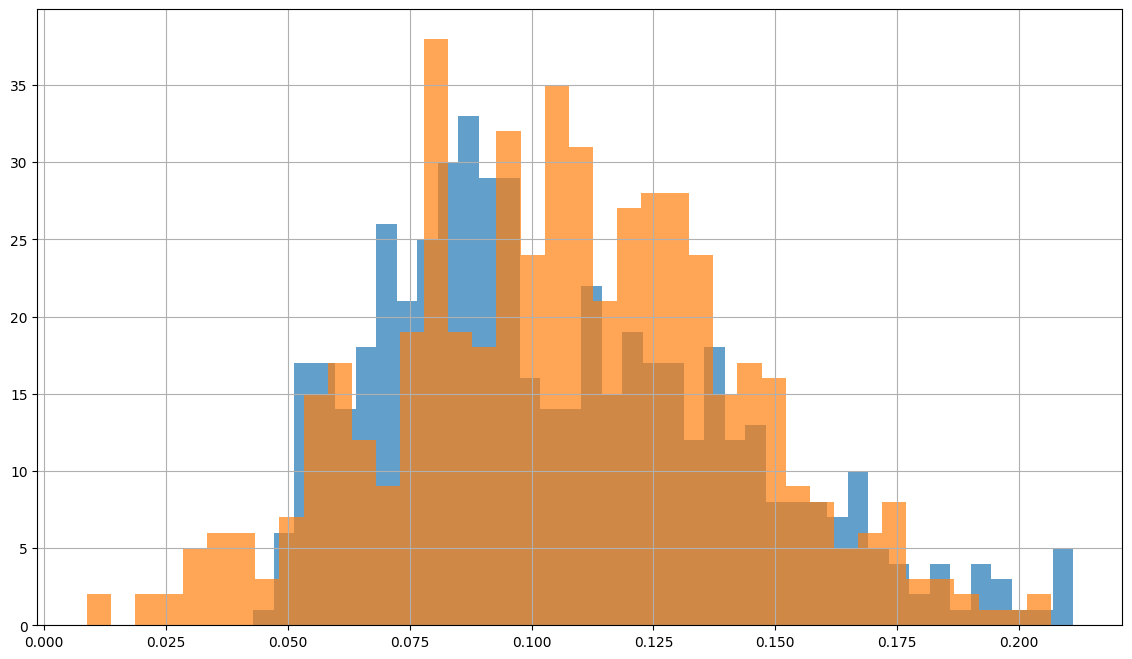

In [168]:

sigma_res = np.std(residuals)

mu_sigma_res = np.mean(sigma_res)
sigma_sigma_res = np.std(sigma_res)


plt.figure(figsize=(14,8))
plt.hist(residuals.std(), bins=40, alpha=0.7)
plt.hist(np.random.normal(mu_sigma_res, sigma_sigma_res, len(sigma_res)), bins=40, alpha=0.7)
plt.grid()
plt.show()

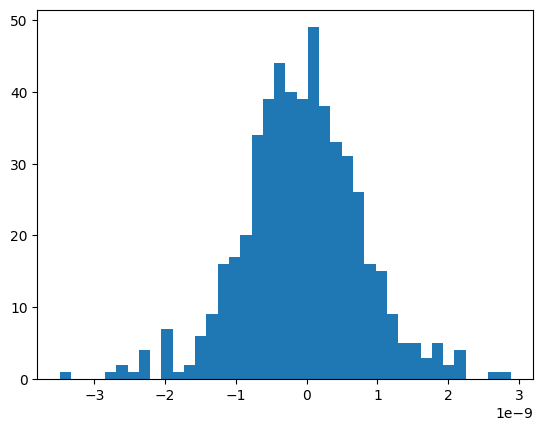

In [156]:
plt.hist(residuals.mean(), bins=40)
plt.show()

In [214]:
def yfinance_log_return(ticker, start='1994-01-01', end='2014-06-01'):
    price = yf.download([ticker], start=start, end=end, interval='1d', back_adjust=True, progress=False)['Close', ticker]
    r = np.log(price.resample('ME').last()) - np.log(price.resample('ME').first())
    return r

def generate_data(r, r_market, shape=None):
    """
    Generate simple synthetic log returns based on single factor model (OLS) and market log returns
    @params:
        r        - Required  : Sample log returns (Array of shape mxn)
        r_market - Required  : Log market returns for the period (Array of shape mx1)
        shape    - Optional  : Shape of synthetic data (Tuple)
    @return:
        s_r     - Synthetic returns
        s_alpha - Synthetic alpha
        s_beta  - Synthetic beta
        s_res   - Synthetic residuals
    """
    if not shape:
        shape = np.shape(r)

    ols = [stats.linregress(r_market, r[i]) for i in r]
    alpha = np.array([ols_i.intercept for ols_i in ols])
    beta = np.array([ols_i.slope for ols_i in ols])

    residuals = r - (np.reshape(r_market, (len(r_market), 1)) @ np.reshape(beta, (1, len(beta))) + alpha)

    mu_res = 0                     # Residual mean is 0, so we only need residual variance
    sigma_res = np.std(residuals)  # Residual variance is specific for a stock so we will generate it using the normal distribution
    
    mu_sigma_res = np.mean(sigma_res)
    sigma_sigma_res = np.std(sigma_res)
    
    mu_a, sigma_a = np.mean(alpha), np.std(alpha)
    mu_b, sigma_b = np.mean(beta),  np.std(beta)

    m, n = shape

    s_alpha = np.random.normal(mu_a, sigma_a, n)
    s_beta = np.random.normal(mu_b, sigma_b, n)
    
    s_sigma_res = np.abs(np.random.normal(mu_sigma_res, sigma_sigma_res, n))
    s_res = np.array([np.random.normal(0, s_sigma_res_i, m) for s_sigma_res_i in s_sigma_res]).T
    
    s_r = s_alpha + np.reshape(r_market, (len(r_market), 1)) @ np.reshape(s_beta, (1, len(s_beta))) + s_res

    return s_r, s_alpha, s_beta, s_res

In [226]:
s_r, s_alpha, s_beta, s_res= generate_data(r, spy)

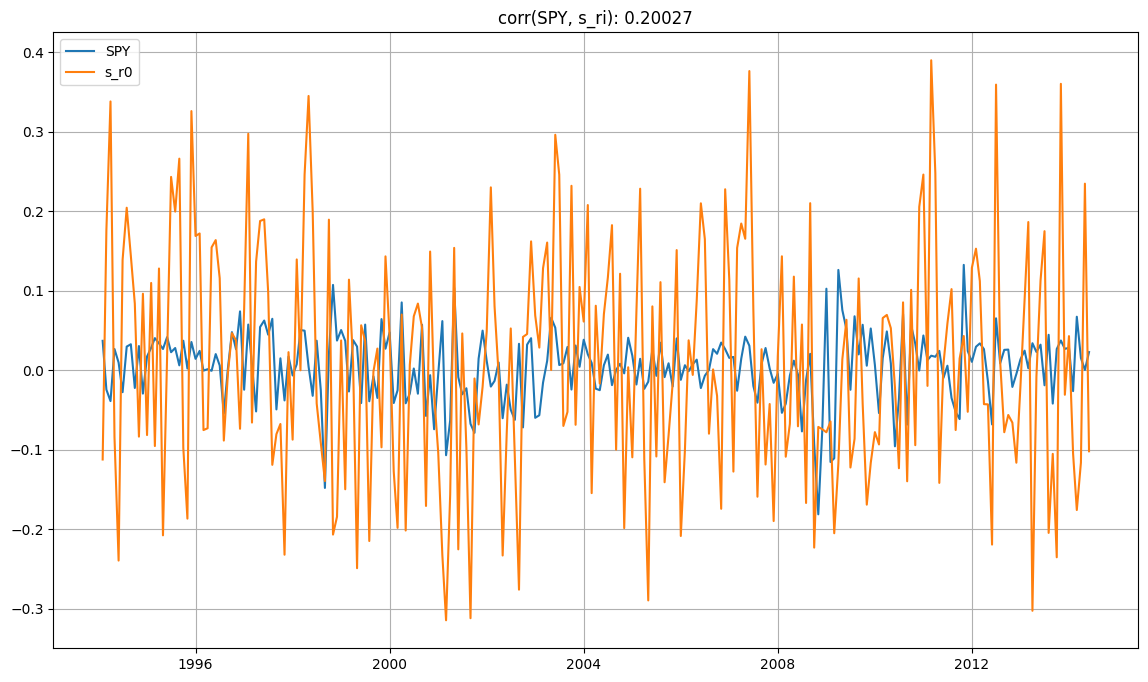

In [239]:
plt.figure(figsize=(14, 8))


plt.plot(spy.index, spy, label='SPY')
plt.plot(spy.index, s_r[:, i], label='s_r0')

plt.title(f'corr(SPY, s_ri): {np.corrcoef(spy, s_r[:, i])[0, 1]:.5f}')

plt.grid()
plt.legend()
plt.show()

In [243]:
i = 6

s_alpha[i], s_beta[i], s_res[:, i]

(np.float64(0.0028443779732596286),
 np.float64(0.9867007557241588),
 array([-0.15156183,  0.19707896,  0.37337581, -0.1131824 , -0.25161874,
         0.16308102,  0.17214474,  0.10892628,  0.10287511, -0.11631882,
         0.12233973, -0.1013509 ,  0.07898837, -0.1379533 ,  0.09164184,
        -0.23677065, -0.02682236,  0.21788958,  0.16904756,  0.25712646,
        -0.13691184, -0.19153265,  0.28790988,  0.151816  ,  0.14507988,
        -0.07758559, -0.07706659,  0.15234124,  0.14074864,  0.10697726,
        -0.03744198, -0.00875068, -0.00347104,  0.00870013, -0.14946115,
         0.09834667,  0.23780531, -0.07509097,  0.18486895,  0.13119118,
         0.12524732,  0.05080676, -0.1855852 , -0.03459091, -0.08521106,
        -0.1973364 ,  0.00297048, -0.08359501,  0.12888937, -0.05285007,
         0.1939174 ,  0.33740451,  0.22851481, -0.08111563, -0.06932429,
         0.00381729,  0.16647788, -0.31529116, -0.22387225, -0.01526703,
        -0.18890586,  0.13738377, -0.03046278, -0.28110